In [67]:
# prevent Fortran routines in NumPy from catching interrupt signal
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'

import sys
import logging
from pathlib import Path
from time import time_ns

import numpy as np
from matplotlib import cm

from rainbow_logging_handler import RainbowLoggingHandler

from PyQt5.QtCore import QTimer, pyqtSignal
from PyQt5.QtWidgets import QApplication, QWidget, QHBoxLayout, QVBoxLayout, QPushButton, QLabel, QLineEdit, QMessageBox, QCheckBox, QDoubleSpinBox
from PyQt5.QtGui import QMouseEvent, QTransform

from vortex.driver.alazar import Board, Channel
from vortex.acquire import AlazarConfig, AlazarAcquisition, InternalClock, ExternalClock, Input, AuxIOTriggerOut
from vortex.process import CUDAProcessor, CUDAProcessorConfig
from vortex.io import DAQmxIO, DAQmxConfig, AnalogVoltageOutput, AnalogVoltageInput, DigitalOutput
from vortex.engine import Block, source, acquire_alazar_clock, find_rising_edges, compute_resampling, dispersion_phasor, SampleStrobe, SegmentStrobe, VolumeStrobe, Polarity

from vortex import Range, get_console_logger as gcl
from vortex.engine import Source, EngineConfig, Engine, StackDeviceTensorEndpointInt8 as StackDeviceTensorEndpoint, AscanStreamEndpoint, CounterStreamEndpoint, GalvoTargetStreamEndpoint, GalvoActualStreamEndpoint, MarkerLogStorage, NullEndpoint
from vortex.format import FormatPlanner, FormatPlannerConfig, StackFormatExecutorConfig, StackFormatExecutor, SimpleSlice
from vortex.marker import Flags, VolumeBoundary, ScanBoundary
from vortex.scan import RasterScanConfig, RadialScanConfig, FreeformScanConfig, FreeformScan, SpiralScanConfig, SpiralScan, limits
from vortex.storage import SimpleStreamInt8, SimpleStreamUInt64, SimpleStreamFloat64, SimpleStreamConfig, SimpleStreamHeader, MarkerLog, MarkerLogConfig

from vortex_tools.ui.backend import NumpyImageWidget
from vortex_tools.ui.display import RasterEnFaceWidget, CrossSectionImageWidget
from vortex.scan import RasterScan

In [68]:
RASTER_FLAGS = Flags(0x1)
RADIAL_FLAGS = Flags(0x2)

scan_dimension=1
bidirectional=False
ascans_per_bscan= 512
bscans_per_volume= 512
galvo_delay=0

aiming_count = 10

clock_samples_per_second=int(1000e6)
blocks_to_acquire=0
ascans_per_block=512
samples_per_ascan=int(1376*2.25)
trigger_delay_seconds=0

blocks_to_allocate=128
preload_count=32

swept_source=Source(200_000, 2858, 0.5, 1)
internal_clock=True
clock_channel=Channel.B
input_channel=Channel.A

process_slots=2
dispersion=(-3e-6, 0)

log_level=1


Text(0.5, 1.0, 'Radial')

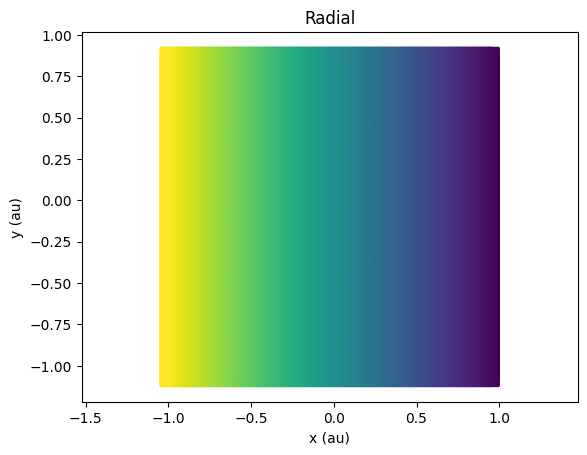

In [69]:
from vortex_tools.scan import plot_annotated_waveforms_space
from vortex.scan import inactive_policy
import math

rsc = RasterScanConfig()
rsc.bscan_extent = Range(-scan_dimension, scan_dimension)
rsc.volume_extent = Range(-scan_dimension, scan_dimension)
rsc.bscans_per_volume = bscans_per_volume
rsc.ascans_per_bscan = ascans_per_bscan
rsc.offset = [-0.025, -0.1]
rsc.angle = np.pi
rsc.bidirectional_segments = bidirectional
rsc.bidirectional_volumes = bidirectional
rsc.limits = [limits.ScannerMax_Saturn_5B]*2
rsc.samples_per_second = swept_source.triggers_per_second
rsc.flags = RASTER_FLAGS

raster_segments = rsc.to_segments()
#pattern = raster_segments

#ffsc = FreeformScanConfig()
#ffsc.pattern = pattern
#ffsc.loop = True

# rsc = RadialScanConfig()
# rsc.bscan_extent = Range(-scan_dimension, scan_dimension)
# rsc.volume_extent = Range(-scan_dimension, scan_dimension)
# rsc.ascans_per_bscan = ascans_per_bscan
# # rsc.offset = [1.85, -1.05]
# rsc.set_half_evenly_spaced(bscans_per_volume)
# rsc.bidirectional_segments = bidirectional
# rsc.bidirectional_volumes = bidirectional
# rsc.limits = [limits.ScannerMax_Saturn_5B]*2
# rsc.samples_per_second = swept_source.triggers_per_second
# rsc.flags = RADIAL_FLAGS
# radial_config = rsc

# radial_segments = rsc.to_segments()
pattern = raster_segments

ffsc = FreeformScanConfig()
ffsc.pattern = pattern
ffsc.loop = True
#ffsc.inactive_policy = inactive_policy.FixedDynamicLimited(512, 512)

scan = FreeformScan()
scan.initialize(ffsc)

_, ax = plot_annotated_waveforms_space(scan.scan_buffer(), scan.scan_markers(), inactive_marker=None, scan_line='w-')
ax.set_title('Radial')

In [70]:
import numpy as np

data = scan.scan_buffer()

#Write the data points of the scan pattern into a txt file
d = open('EnginePattern_raster_amp1_res512.txt', 'w+')
print(*data, file = d)

d.close()

np.save('EnginePattern_raster_amp1_res512.npy', data)

In [71]:
print(len(data))
data[0]
datapoints = np.load('EnginePattern_raster_amp1_res512.npy')
lin_length = len(datapoints)

335360


In [72]:
import struct
import numpy as np

SCALE_FACTOR = 15

#Original
def ang_to_pos(ang):
    if abs(ang) >= SCALE_FACTOR:
        raise Exception("Magnitude of Angle Exceeds Scale Factor")
    pos  = (ang  / SCALE_FACTOR) * 32768 + 32768
    pos = round(pos)
    return pos

def pos_to_ang(pos):
    if pos > 65535 or pos < 0:
        raise Exception("Value of Position Exceeds 2^16 - 1")
    ang = ((pos - 32768) / 32768) * SCALE_FACTOR
    return ang

In [73]:
f = open('EnginePattern_raster_amp1_res512_hexadecimal_downsample.txt', 'w+')
for j in range(0, 1):
    for i in range(0, len(datapoints)):
        pointX = datapoints[i][0]
        hexaX = hex(ang_to_pos(pointX))
        hexaX = hexaX[2:]
        pointY = datapoints[i][1]
        hexaY = hex(ang_to_pos(pointY))
        hexaY = hexaY[2:]
        if(i % 4 == 0):
            print(hexaX + hexaY, file = f)
            # print(i/4)
print((i+1) // 4 // 32)
f.close()

2620


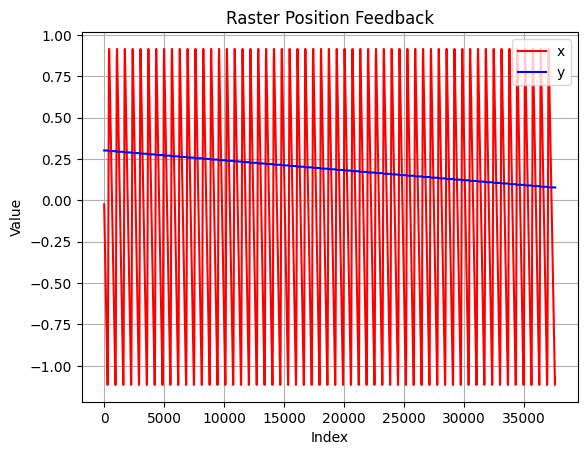

In [74]:
import matplotlib.pyplot as plt

#plt.figure(figsize=(8, 4))

plt.plot(datapoints[3 * 4 * 9408: 4 * 4 * 9408, 1], color='red', label='x')
plt.plot(datapoints[3 * 4 * 9408: 4 * 4 * 9408, 0], color = 'blue', label = 'y')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Raster Position Feedback')
plt.legend()
plt.grid(True)
plt.show()


In [75]:
datapoints[100][1]

0.508610567514677

In [76]:
type(datapoints)

numpy.ndarray

In [77]:
from pathlib import Path
print(Path().resolve())

S:\Digital_Interface
